What if evaluating the values of function f is not cheap? Maybe even NP-hard?
Then we can't just sample some random grid to approximate it.

Bayessian optimization will help you. In Bayessian optimization we upadate prior belief with samples drawn from it directed by acquisition function. So we can sample next point and evaluate f in areas where an improvement over the current best observation is likely.

## Algorithm
The Bayesian optimization procedure is as follows. For $t=1,2,\dots$ repeat:

Find the next sampling point $x_t$ by optimizing the acquisition function over the GP:
$x_t=\text{argmax}_x u(x|D_{1:t−1})$

Obtain a possibly noisy sample $y_t=f(x_t)+\varepsilon_t$ from the objective function $f$.

Add the sample to previous samples $D_{1:t}={D_{1:t−1},(xt,yt)}$
 and update the GP.

## Acquisition function

Popular acquisition functions are maximum probability of improvement(MPI), expected improvement(EI) and upper confidence bound(UCB).

### Expected improvement

$$\text{EI} (x) = \mathbb{E} \max(f(x) - f(x^+), 0)$$

$$x^+=\text{argmax}_{x_i\in x_{1:t}}f(x_i)$$

Under GP model we obtain:

$$\text{EI} (x) = \begin{cases} (\mu (x) - f(x^+) - \xi)\Phi(Z) + \sigma(x)\phi(Z), &\sigma(x) > 0 \\ 0, &\sigma(x) =0 \end{cases}$$

where $$Z = \begin{cases} \frac{\mu (x) - f(x^+) - \xi}{\sigma(x)} , &\sigma(x) > 0 \\ 0, &\sigma(x) = 0\end{cases}$$

where $\mu (x)$
 and $\sigma(x)$
 are the mean and the standard deviation of the GP pesterior predictive at $x$
, respectively. $\Phi$
 and $\phi$
 are the CDF and PDF of the standard normal distribution, respectively.

In [28]:
import numpy as np

%matplotlib inline

bounds = np.array([[-1.0, 2.0]])
noise = 0.1

def f(X, noise=noise):
    return -np.sin(3*X) - X**2 + 0.7*X + noise * np.random.randn(*X.shape)

X_init = np.array([[-0.9], [1.1]])
Y_init = f(X_init)

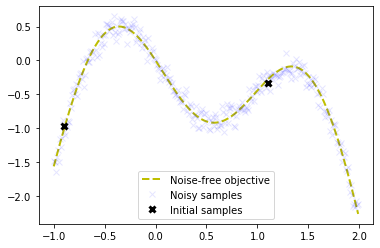

In [29]:
import matplotlib.pyplot as plt

# Dense grid of points within bounds
X = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)

# Noise-free objective function values at X 
Y = f(X,0)

# Plot optimization objective with noise level 
plt.plot(X, Y, 'y--', lw=2, label='Noise-free objective')
plt.plot(X, f(X), 'bx', lw=1, alpha=0.1, label='Noisy samples')
plt.plot(X_init, Y_init, 'kx', mew=3, label='Initial samples')
plt.legend()

In [3]:
from scipy.stats import norm

def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
    '''
    Computes the EI at points X based on existing samples X_sample
    and Y_sample using a Gaussian process surrogate model.
    
    Args:
        X: Points at which EI shall be computed (m x d).
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.
        xi: Exploitation-exploration trade-off parameter.
    
    Returns:
        Expected improvements at points X.
    '''
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample = gpr.predict(X_sample)

    sigma = sigma.reshape(-1, 1)
    
    # Needed for noise-based model,
    # otherwise use np.max(Y_sample).
    # See also section 2.4 in [...]
    mu_sample_opt = np.max(mu_sample)

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei

In [40]:
def probability_improvement(X, X_sample, Y_sample, gpr, xi=0.05):
    '''
    Computes the MPI at points X based on existing samples X_sample
    and Y_sample using a Gaussian process surrogate model.
    
    Args:
        X: Points at which EI shall be computed (m x d).
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.
        xi: Exploitation-exploration trade-off parameter.
    
    Returns:
        Expected improvements at points X.
    '''
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample = gpr.predict(X_sample)

    sigma = sigma.reshape(-1, 1)
    
    # Needed for noise-based model,
    # otherwise use np.max(Y_sample).
    # See also section 2.4 in [...]
    mu_sample_opt = np.max(mu_sample)

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        pi = norm.cdf(Z)
        pi[sigma == 0.0] = 0.0

    return pi

In [43]:
def UCB(X, X_sample, Y_sample, gpr, beta=1):
    '''
    Computes the MPI at points X based on existing samples X_sample
    and Y_sample using a Gaussian process surrogate model.
    
    Args:
        X: Points at which EI shall be computed (m x d).
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.
        xi: Exploitation-exploration trade-off parameter.
    
    Returns:
        Expected improvements at points X.
    '''
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample = gpr.predict(X_sample)

    sigma = sigma.reshape(-1, 1)
    return mu + np.sqrt(beta) * sigma

In [4]:
from scipy.optimize import minimize

def propose_location(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=25):
    '''
    Proposes the next sampling point by optimizing the acquisition function.
    
    Args:
        acquisition: Acquisition function.
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.

    Returns:
        Location of the acquisition function maximum.
    '''
    dim = X_sample.shape[1]
    min_val = 1
    min_x = None
    
    def min_obj(X):
        # Minimization objective is the negative acquisition function
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gpr)
    
    # Find the best optimum by starting from n_restart different random points.
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')        
        if res.fun < min_val:
            min_val = res.fun[0]
            min_x = res.x           
            
    return min_x.reshape(-1, 1)

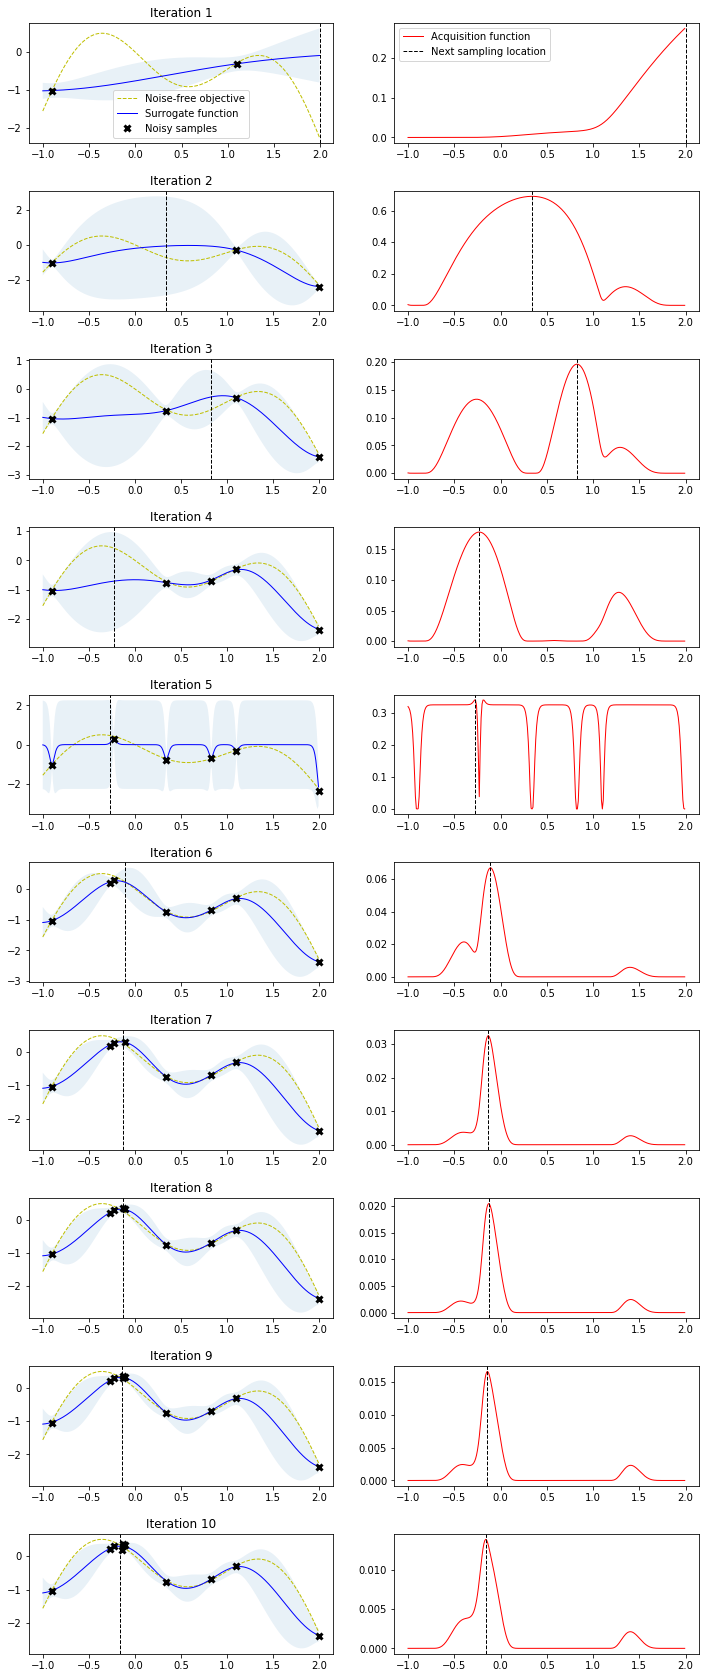

In [5]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern
from bayesian_optimization_util import plot_approximation, plot_acquisition

# Gaussian process with Mat??rn kernel as surrogate model
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

# Initialize samples
X_sample = X_init
Y_sample = Y_init

# Number of iterations
n_iter = 10

plt.figure(figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.4)

for i in range(n_iter):
    # Update Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next = propose_location(expected_improvement, X_sample, Y_sample, gpr, bounds)
    
    # Obtain next noisy sample from the objective function
    Y_next = f(X_next, noise)
    
    # Plot samples, surrogate function, noise-free objective and next sampling location
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next, show_legend=i==0)
    plt.title(f'Iteration {i+1}')

    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition(X, expected_improvement(X, X_sample, Y_sample, gpr), X_next, show_legend=i==0)
    
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))

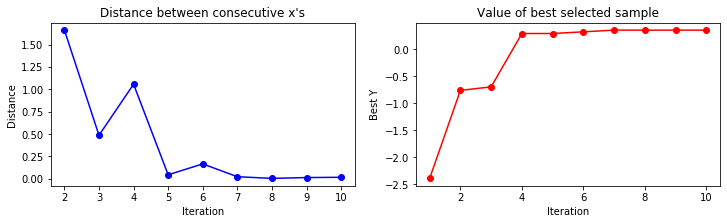

In [6]:
from bayesian_optimization_util import plot_convergence

plot_convergence(X_sample, Y_sample)

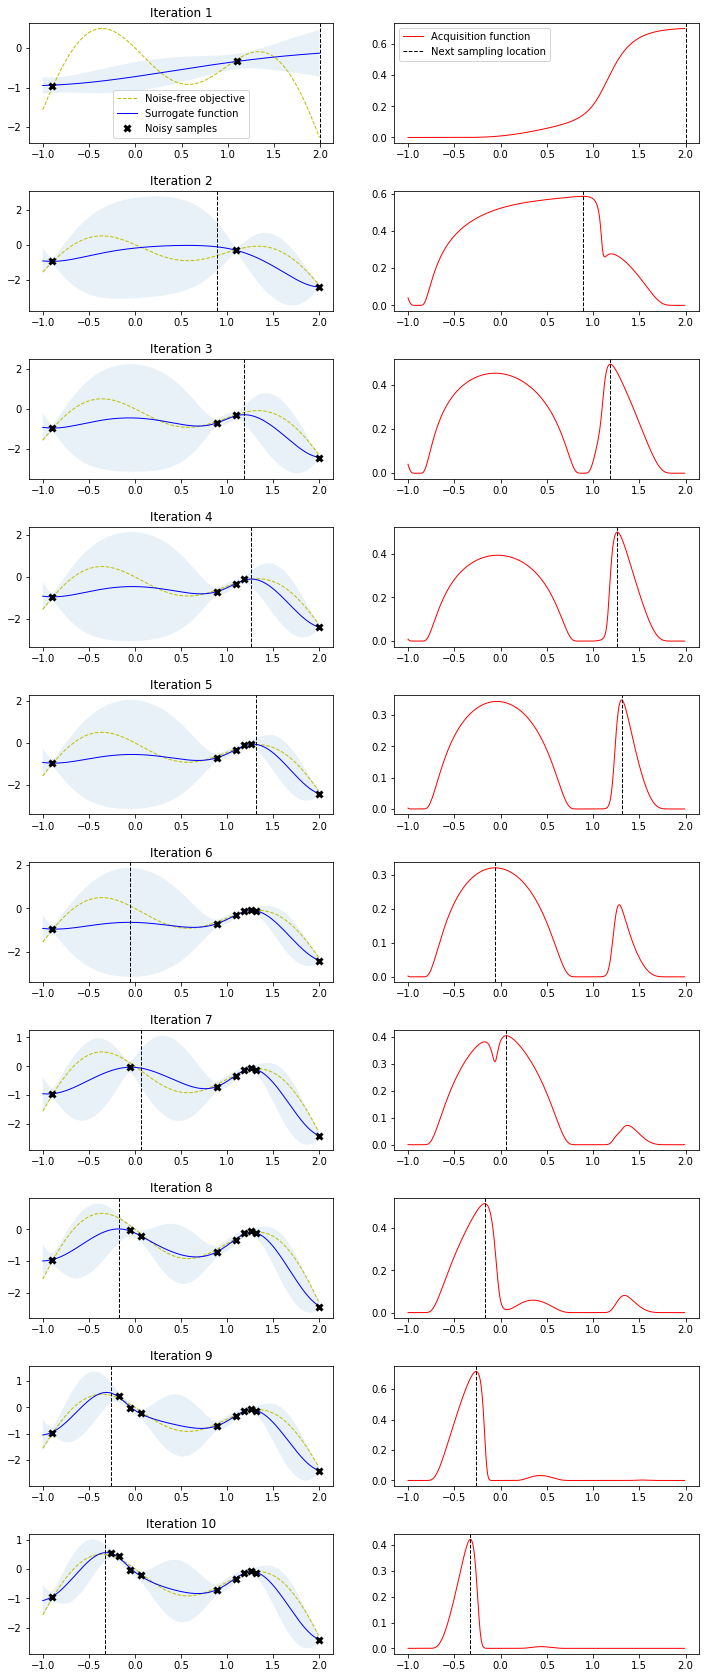

In [41]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern
from bayesian_optimization_util import plot_approximation, plot_acquisition

# Gaussian process with Mat??rn kernel as surrogate model
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

# Initialize samples
X_sample = X_init
Y_sample = Y_init

# Number of iterations
n_iter = 10

plt.figure(figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.4)

for i in range(n_iter):
    # Update Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next = propose_location(probability_improvement, X_sample, Y_sample, gpr, bounds)
    
    # Obtain next noisy sample from the objective function
    Y_next = f(X_next, noise)
    
    # Plot samples, surrogate function, noise-free objective and next sampling location
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next, show_legend=i==0)
    plt.title(f'Iteration {i+1}')

    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition(X, probability_improvement(X, X_sample, Y_sample, gpr), X_next, show_legend=i==0)
    
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))

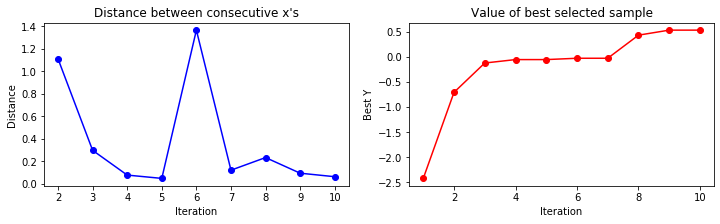

In [42]:
from bayesian_optimization_util import plot_convergence

plot_convergence(X_sample, Y_sample)

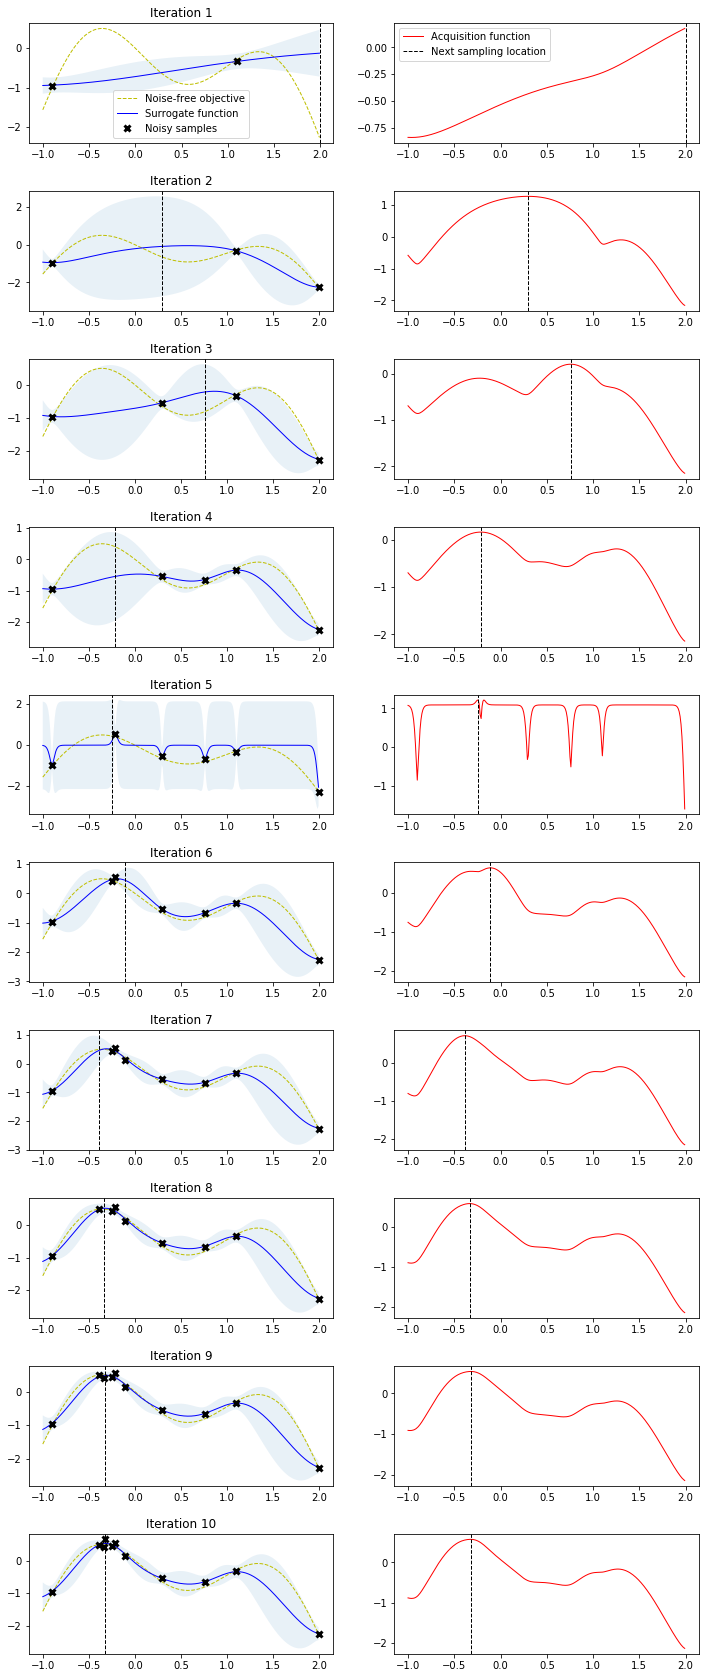

In [45]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern
from bayesian_optimization_util import plot_approximation, plot_acquisition

# Gaussian process with Mat??rn kernel as surrogate model
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

# Initialize samples
X_sample = X_init
Y_sample = Y_init

# Number of iterations
n_iter = 10

plt.figure(figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.4)

for i in range(n_iter):
    # Update Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next = propose_location(UCB, X_sample, Y_sample, gpr, bounds)
    
    # Obtain next noisy sample from the objective function
    Y_next = f(X_next, noise)
    
    # Plot samples, surrogate function, noise-free objective and next sampling location
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next, show_legend=i==0)
    plt.title(f'Iteration {i+1}')

    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition(X, UCB(X, X_sample, Y_sample, gpr), X_next, show_legend=i==0)
    
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))

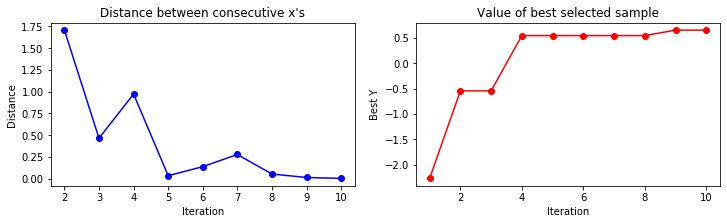

In [46]:
from bayesian_optimization_util import plot_convergence

plot_convergence(X_sample, Y_sample)

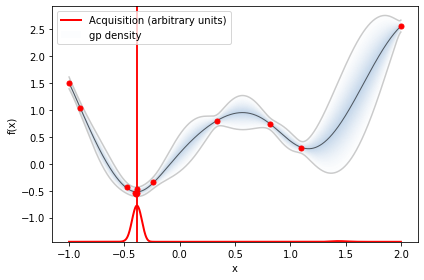

In [7]:
import GPy
import GPyOpt

from GPyOpt.methods import BayesianOptimization

kernel = GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0)
bds = [{'name': 'X', 'type': 'continuous', 'domain': bounds.ravel()}]

optimizer = BayesianOptimization(f=f, 
                                 domain=bds,
                                 model_type='GP',
                                 kernel=kernel,
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.01,
                                 X=X_init,
                                 Y=-Y_init,
                                 noise_var = noise**2,
                                 exact_feval=False,
                                 normalize_Y=False,
                                 maximize=True)

optimizer.run_optimization(max_iter=10)
optimizer.plot_acquisition()

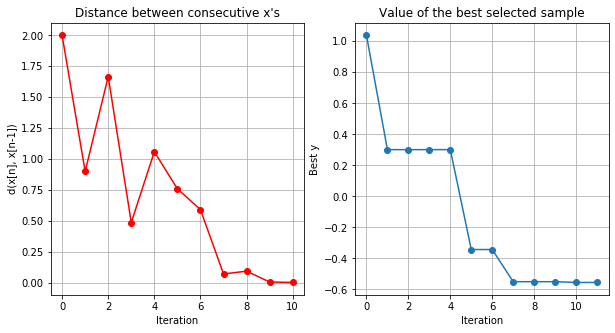

In [9]:
optimizer.plot_convergence()

# Example

In [11]:
from sklearn import datasets
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

from scipy.stats import uniform
from sklearn.ensemble import GradientBoostingRegressor

# Load the diabetes dataset (for regression)
X, Y = datasets.load_diabetes(return_X_y=True)

# Instantiate an XGBRegressor with default hyperparameter settings
gb = GradientBoostingRegressor()

# and compute a baseline to beat with hyperparameter optimization 
baseline = cross_val_score(gb, X, Y, scoring='neg_mean_squared_error').mean()

In [16]:
baseline

-3554.011600524663

In [14]:
param_dist = {"learning_rate": uniform(0, 1),
              "max_depth": range(1,50),
              "n_estimators": range(1,300)}

rs = RandomizedSearchCV(gb, param_distributions=param_dist, 
                        scoring='neg_mean_squared_error', n_iter=25)

rs.fit(X, Y)

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=GradientBoostingRegressor(alpha=0.9,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                       

In [15]:
rs.best_score_

-3338.08632105451

In [22]:
bds = [{'name': 'learning_rate', 'type': 'continuous', 'domain': (1e-20, 1)},
        {'name': 'max_depth', 'type': 'discrete', 'domain': (1, 50)},
        {'name': 'n_estimators', 'type': 'discrete', 'domain': (1, 300)}]

# Optimization objective 
def cv_score(parameters):
    parameters = parameters[0]
    score = cross_val_score(
                GradientBoostingRegressor(learning_rate=parameters[0],
                              max_depth=int(parameters[1]),
                              n_estimators=int(parameters[2])), 
                X, Y, scoring='neg_mean_squared_error').mean()
    score = np.array(score)
    return score

optimizer = BayesianOptimization(f=cv_score, 
                                 domain=bds,
                                 model_type='GP',
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.05,
                                 exact_feval=True, 
                                 maximize=True)

# Only 20 iterations because we have 5 initial random points
optimizer.run_optimization(max_iter=20)

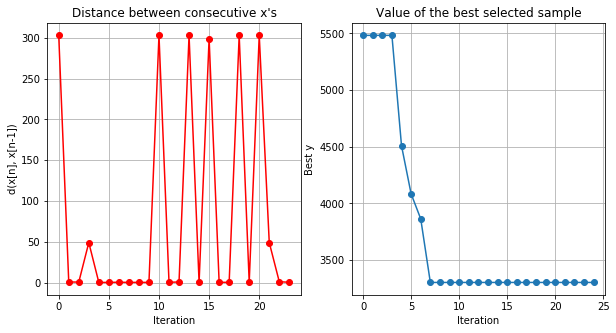

In [23]:
optimizer.plot_convergence()

Baseline neg. MSE = -3554.01
Random search neg. MSE = -3338.09
Bayesian optimization neg. MSE = -3303.19


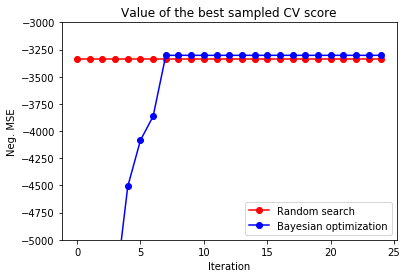

In [25]:
y_rs = np.maximum.accumulate(rs.cv_results_['mean_test_score'])
y_bo = np.maximum.accumulate(-optimizer.Y).ravel()

print(f'Baseline neg. MSE = {baseline:.2f}')
print(f'Random search neg. MSE = {y_rs[-1]:.2f}')
print(f'Bayesian optimization neg. MSE = {y_bo[-1]:.2f}')

plt.plot(y_rs, 'ro-', label='Random search')
plt.plot(y_bo, 'bo-', label='Bayesian optimization')
plt.xlabel('Iteration')
plt.ylabel('Neg. MSE')
plt.ylim(-5000, -3000)
plt.title('Value of the best sampled CV score');
plt.legend();